# Libs

In [1]:
import time
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from bernstein_flow.activations import get_thetas_constrain_fn
from bernstein_flow.bijectors import BernsteinBijectorLinearExtrapolate
from bernstein_flow.distributions import BernsteinFlow
from bernstein_flow.util.visualization import plot_flow
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras as K
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow_probability.python.internal import (
    dtype_util,
    prefer_static,
    tensor_util,
)

2023-03-22 15:58:06.139723: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 15:58:06.139788: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Seed

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Functions

In [3]:
# Construct and fit model.
# @tf.function
def fit_distribution(
    model,
    x_data,
    y_data,
    epochs=200,
    batch_size=64,
    extra_variables=None,
    learning_rate=0.001,
    **kwds,
):
    set_seed(1)
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
        loss=lambda y, dist: -dist.log_prob(y),
    )

    lr_patience = 10
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            # monitor="val_loss",
            monitor="loss",
            factor=0.1,
            patience=lr_patience,
        ),
        tf.keras.callbacks.EarlyStopping(
            # monitor="val_loss",
            monitor="loss",
            patience=3 * lr_patience,
            restore_best_weights=True,
        ),
        tf.keras.callbacks.TerminateOnNaN(),
    ]

    return model.fit(
        x=x_data,
        y=y_data,
        batch_size=batch_size,
        epochs=epochs,
        # validation_split=0.2,
        # steps_per_epoch=1,  # Usually `n // batch_size`.
        shuffle=True,
        callbacks=callbacks,
        **kwds,
    )

In [4]:
def plot_samples(dist, train_data, seed=1, ax=plt):
    set_seed(seed)
    N = train_data.shape[0]
    # Use the fitted distribution.
    start = time.time()
    samples = dist.sample((N,))
    end = time.time()
    print(f"sampling took {end-start} seconds.")

    df1 = pd.DataFrame(columns=["x1", "x2"], data=train_data)
    df1 = df1.assign(source="data")

    df2 = pd.DataFrame(columns=["x1", "x2"], data=samples.numpy())
    df2 = df2.assign(source="model")

    df = df1.append(df2, ignore_index=True)

    # sns.jointplot(data=df, x='x1', y='x2', hue='source', kind='kde')
    g = sns.jointplot(data=df, x="x1", y="x2", hue="source", ax=plt)
    g.plot_joint(sns.kdeplot, zorder=0)
    # g.plot_marginals(sns.rugplot, height=-.15)

# Data

In [5]:
data = pd.read_csv("india.raw", sep="\s+")

In [6]:
targets = ["stunting", "wasting", "underweight"]
covariates = data.columns[~data.columns.isin(targets)].to_list()

In [7]:
test_size = 0.1
val_size = 0.1

In [8]:
set_seed(1)
train_val_data, test_data = train_test_split(data, test_size=test_size, shuffle=True)
train_data, val_data = train_test_split(
    train_val_data, test_size=val_size, shuffle=True
)
del train_val_data, data

In [9]:
ct = make_column_transformer(
    (MinMaxScaler(), targets),
    remainder=StandardScaler(),
    verbose_feature_names_out=False,
)
ct.set_output(transform="pandas")

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['stunting', 'wasting', 'underweight'])],
                  verbose_feature_names_out=False)

In [10]:
train_data_scaled = ct.fit_transform(train_data)
val_data_scaled = ct.transform(val_data)
test_data_scaled = ct.transform(test_data)

In [11]:
assert train_data_scaled.index.isin(test_data_scaled.index).any() == False
assert train_data_scaled.index.isin(val_data_scaled.index).any() == False
assert val_data_scaled.index.isin(test_data_scaled.index).any() == False

In [12]:
t = partial(tf.convert_to_tensor, dtype=tf.float32)

In [13]:
train_x, train_y = t(train_data_scaled[covariates]), t(train_data_scaled[targets])
val_x, val_y = t(val_data_scaled[covariates]), t(val_data_scaled[targets])
test_x, test_y = t(test_data_scaled[covariates]), t(test_data_scaled[targets])

2023-03-22 15:58:15.403345: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 15:58:15.403438: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 15:58:15.403569: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arch.MarcelPC.fritz.box): /proc/driver/nvidia/version does not exist
2023-03-22 15:58:15.405235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


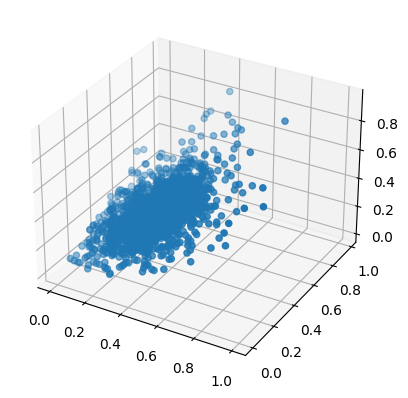

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(*train_data_scaled[targets].sample(frac=0.1).values.T)

In [15]:
def plot_samples_grid(data, **kwds):
    sns.set_theme(style="white")

    g = sns.PairGrid(data, diag_sharey=False, **kwds)
    g.map_upper(sns.scatterplot, s=15)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.kdeplot, lw=2)
    return g

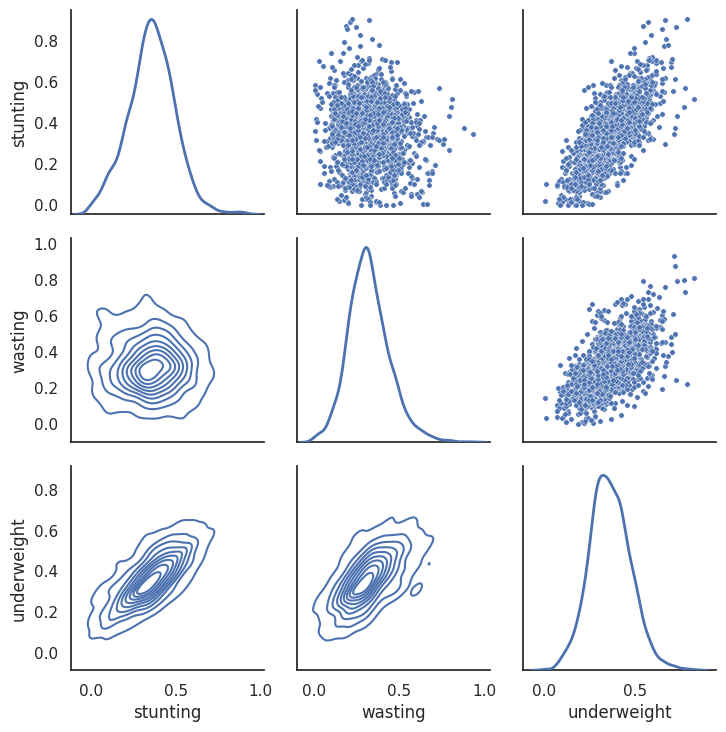

In [16]:
plot_samples_grid(train_data_scaled[targets].sample(frac=0.1))

# Multivariate Conditional Transformation Models

the model-based density function for $Y$ is therefore

$f_{\boldsymbol{Y}}(\boldsymbol{y})=\prod_{j=1}^{J} \phi_{0,1}\left(\lambda_{j 1} \tilde{h}_{1}\left(y_{1}\right)+\ldots+\lambda_{j, j-1} \tilde{h}_{j-1}\left(y_{j-1}\right)+\tilde{h}_{j}\left(y_{j}\right)\right) \frac{\partial \tilde{h}_{j}\left(y_{j}\right)}{\partial y_{j}}$

Summarising the model's specifications, our multivariate transformation model is characterised by a set of marginal transformations $\tilde{h}_{j}\left(y_{j}\right), j=1, \ldots, J$, each applying to only a single component of the vector $\boldsymbol{Y}$, and by a lower triangular $(J \times J)$ matrix of transformation coefficients

$\boldsymbol{\Lambda}=\left(\begin{array}{ccccc}1 & & & & 0 \\ \lambda_{21} & 1 & & & \\ \lambda_{31} & \lambda_{32} & 1 & & \\ \vdots & \vdots & & \ddots & \\ \lambda_{J 1} & \lambda_{J 2} & \ldots & \lambda_{J, J-1} & 1\end{array}\right)$

For the transformation functions $\tilde{h}_{j}$, the explicit representation
$$
\tilde{h}_{j}\left(Y_{j}\right)=\Phi_{0, \sigma_{j}^{2}}^{-1}\left(F_{j}\left(Y_{j}\right)\right)=\tilde{Z}_{j}
$$
is obtained, where $F_{j}(\cdot)$ is the univariate marginal CDF of $Y_{j}$. In summary,
$$
\begin{aligned}
\mathbb{P}(\boldsymbol{Y} \leq \boldsymbol{y}) &=\mathbb{P}(\tilde{\boldsymbol{Z}} \leq \tilde{\boldsymbol{z}})=\Phi_{0, \boldsymbol{\Sigma}}(\tilde{\boldsymbol{z}})=\Phi_{\mathbf{0}, \boldsymbol{\Sigma}}\left[\Phi_{0, \sigma_{1}^{2}}^{-1}\left\{F_{1}\left(y_{1}\right)\right\}, \ldots, \Phi_{0, \sigma_{J}^{2}}^{-1}\left\{F_{J}\left(y_{J}\right)\right\}\right] \\
&=\Phi_{0, \boldsymbol{\Sigma}}\left(\tilde{h}_{1}\left(y_{1}\right), \ldots, \tilde{h}_{J}\left(y_{J}\right)\right)
\end{aligned}
$$
and therefore the CDF of $\boldsymbol{Y}$ has exactly the same structure as a Gaussian copula, except that our representation relies on a different parameterisation of $\boldsymbol{\Sigma}$ through $\boldsymbol{\Sigma}=\Lambda^{-1} \Lambda^{-\top}$.

## Parameter Model

In [17]:
def get_model(input_shape, output_shape, dist_lambda):
    set_seed(1)
    inputs = K.Input(input_shape)
    x = K.layers.Dense(32, activation="relu", name="hidden1")(inputs)
    x = K.layers.Dense(32, activation="relu", name="hidden2")(x)
    pv = K.layers.Dense(output_shape, activation="linear", name="pv")(x)
    dist = tfp.layers.DistributionLambda(dist_lambda)(pv)
    param_model = K.Model(inputs=inputs, outputs=dist)
    param_model.summary()
    return param_model

In [18]:
P = partial(get_model, input_shape=len(covariates))

In [19]:
dim = len(targets)

## Multivariate Normal

In [20]:
def get_multivariate_normal(pv):
    loc = pv[..., :3]
    scale_tril = tfp.math.fill_triangular(pv[..., 3:])
    mv_normal = tfd.MultivariateNormalTriL(loc=loc, scale_tril=scale_tril)
    return mv_normal

In [21]:
mn_model = P(
    output_shape=dim + np.sum(np.arange(dim + 1)), dist_lambda=get_multivariate_normal
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 hidden1 (Dense)             (None, 32)                1312      
                                                                 
 hidden2 (Dense)             (None, 32)                1056      
                                                                 
 pv (Dense)                  (None, 9)                 297       
                                                                 
 distribution_lambda (Distri  ((None, 3),              0         
 butionLambda)                (None, 3))                         
                                                                 
Total params: 2,665
Trainable params: 2,665
Non-trainable params: 0
___________________________________________________________

In [26]:
fit_distribution(
    mn_model,
    x_data=train_x,
    y_data=train_y,
    batch_size=1024,
    # steps_per_epoch=10,
    learning_rate=0.001,
)

Epoch 1/200
20/20 [==============================] - 4s 13ms/step - loss: 149.5771 - lr: 0.0100
Epoch 2/200
20/20 [==============================] - 0s 15ms/step - loss: 193.2789 - lr: 0.0100
Epoch 3/200
20/20 [==============================] - 0s 14ms/step - loss: 229.0245 - lr: 0.0100
Epoch 4/200
20/20 [==============================] - 0s 14ms/step - loss: 16.2236 - lr: 0.0100
Epoch 5/200
20/20 [==============================] - 0s 13ms/step - loss: 79.0268 - lr: 0.0100
Epoch 6/200
20/20 [==============================] - 0s 13ms/step - loss: 344.8740 - lr: 0.0100
Epoch 7/200
20/20 [==============================] - 0s 15ms/step - loss: 106.3434 - lr: 0.0100
Epoch 8/200
20/20 [==============================] - 0s 13ms/step - loss: 649.2292 - lr: 0.0100
Epoch 9/200
20/20 [==============================] - 0s 15ms/step - loss: 924.5303 - lr: 0.0100
Epoch 10/200
20/20 [==============================] - 0s 14ms/step - loss: 1139.2375 - lr: 0.0100
Epoch 11/200
20/20 [====================

In [27]:
mn_samples = mn_model(val_x).sample(10)
mn_samples.shape

TensorShape([10, 2186, 3])

In [28]:
df = pd.DataFrame(mn_samples.numpy().reshape([-1, 3]), columns=targets)

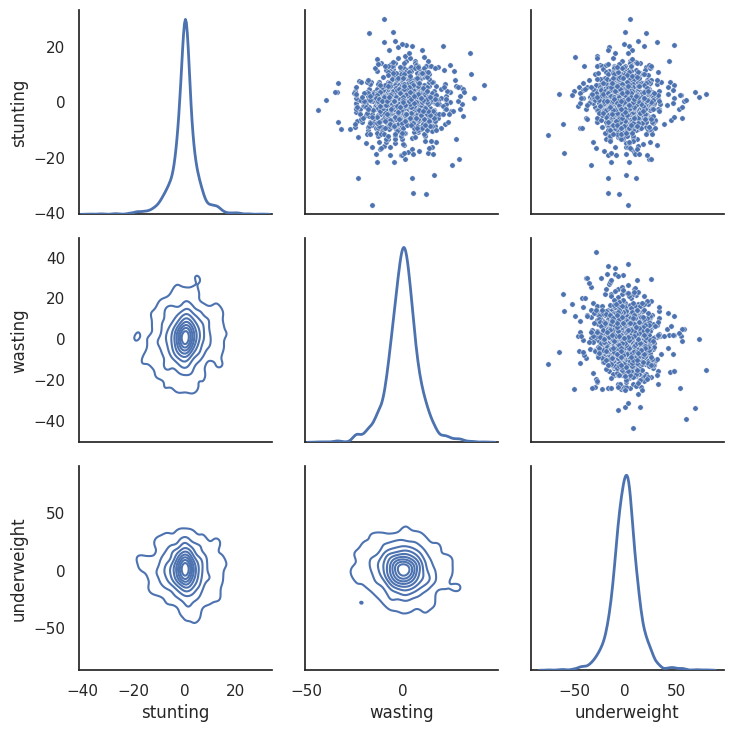

In [29]:
plot_samples_grid(df.sample(frac=0.1))

## BernsteinCopulaTriLtrain_data_scaled

In [102]:
class BernsteinCopulaTriL(BernsteinFlow):
    def __init__(self, thetas, scale_tril, name="BernsteinCopulaTriL", **kwds):
        with tf.name_scope(name) as name:
            parameters = dict(locals())
            dtype = dtype_util.common_dtype([scale_tril, thetas], dtype_hint=tf.float32)

            scale_tril = tensor_util.convert_nonref_to_tensor(
                scale_tril, dtype=dtype, name="scale_tril"
            )

            # scale_tril = tf.linalg.inv(lmbd) @ tf.linalg.inv(tf.transpose(lmbd))
            # scale_tril = tfp.math.
            mv_normal = tfd.MultivariateNormalTriL(loc=0, scale_tril=scale_tril)
            # print(mv_normal)
            super().__init__(
                thetas=thetas,
                base_distribution=mv_normal,
                name=name,
                **kwds,
            )
            self._parameters = parameters

    def _parameter_properties(self, dtype=None, num_classes=None):
        # Annotations may optionally specify properties, such as `event_ndims`,
        # `default_constraining_bijector_fn`, `specifies_shape`, etc.; see
        # the `ParameterProperties` documentation for details.
        return dict(
            lmbd=tfp.util.ParameterProperties(),
        )

In [103]:
bnf_kwds = dict(
    # extrapolation="quadractic",
    bb_class=BernsteinBijectorLinearExtrapolate,
    clip_to_bernstein_domain=False,  # No Sigmoid,
    # scale_data=True,
    # shift_data=True,
    scale_base_distribution=False,
    thetas_constrain_fn=get_thetas_constrain_fn(
        low=-3,
        high=3,
        smooth_bounds=True,
        allow_flexible_bounds=True,
        fn=tf.math.softplus,
        eps=1e-04,
    ),
)

In [104]:
def get_mctm(pv):
    #bs=prefer_static.shape(pv)[:-1]
    #shape = tf.concat((bs, [dim, -1]), 0)
    shape=(-1, dim, M)
    bnf_pv = tf.reshape(pv[..., 6:], shape)
    scale_tril = tfp.math.fill_triangular(pv[..., :6])
    return BernsteinCopulaTriL.from_pvector(bnf_pv, scale_tril=scale_tril)#, **bnf_kwds)

In [105]:
get_mctm(tf.ones((32, dim * M + np.sum(np.arange(dim + 1)))))

<tfp.distributions.BernsteinCopulaTriL 'BernsteinCopulaTriL' batch_shape=[] event_shape=[3] dtype=float32>

In [106]:
M = 20
mctm_model = P(output_shape=dim * M + np.sum(np.arange(dim + 1)), dist_lambda=get_mctm)

ValueError: Exception encountered when calling layer "distribution_lambda_19" (type DistributionLambda).

Error processing property 'tensor_distribution' of <tfp.distributions.BernsteinCopulaTriL 'BernsteinCopulaTriL' batch_shape=[] event_shape=[3] dtype=float32>

Call arguments received by layer "distribution_lambda_19" (type DistributionLambda):
  • inputs=tf.Tensor(shape=(None, 66), dtype=float32)
  • args=<class 'inspect._empty'>
  • kwargs={'training': 'None'}

In [26]:
fit_distribution(
    mn_model,
    x_data=train_x,
    y_data=train_y,
    batch_size=1024,
    #steps_per_epoch=10,
    learning_rate=0.001,
)

Epoch 1/200
20/20 [==============================] - 4s 13ms/step - loss: 149.5771 - lr: 0.0100
Epoch 2/200
20/20 [==============================] - 0s 15ms/step - loss: 193.2789 - lr: 0.0100
Epoch 3/200
20/20 [==============================] - 0s 14ms/step - loss: 229.0245 - lr: 0.0100
Epoch 4/200
20/20 [==============================] - 0s 14ms/step - loss: 16.2236 - lr: 0.0100
Epoch 5/200
20/20 [==============================] - 0s 13ms/step - loss: 79.0268 - lr: 0.0100
Epoch 6/200
20/20 [==============================] - 0s 13ms/step - loss: 344.8740 - lr: 0.0100
Epoch 7/200
20/20 [==============================] - 0s 15ms/step - loss: 106.3434 - lr: 0.0100
Epoch 8/200
20/20 [==============================] - 0s 13ms/step - loss: 649.2292 - lr: 0.0100
Epoch 9/200
20/20 [==============================] - 0s 15ms/step - loss: 924.5303 - lr: 0.0100
Epoch 10/200
20/20 [==============================] - 0s 14ms/step - loss: 1139.2375 - lr: 0.0100
Epoch 11/200
20/20 [====================

In [27]:
mn_samples = mn_model(val_x).sample(10)
mn_samples.shape

TensorShape([10, 2186, 3])

In [28]:
df = pd.DataFrame(mn_samples.numpy().reshape([-1, 3]), columns=targets)

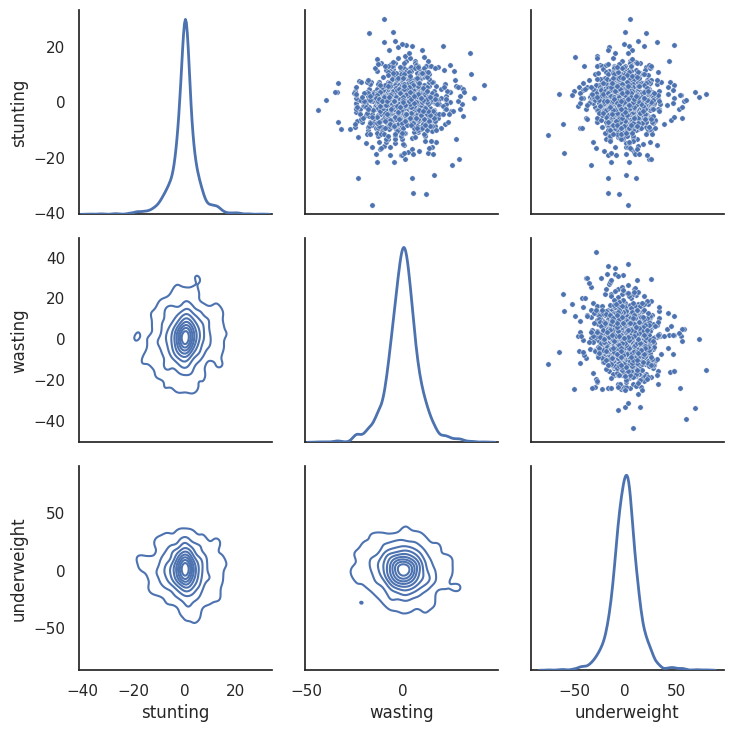

In [29]:
plot_samples_grid(df.sample(frac=0.1))

In [86]:
set_seed(1)

In [87]:
dims = 3
M = 20

inputs = K.Input(len(covariates))
x = K.layers.Dense(16, activation="relu", name="hidden1")(inputs)
x = K.layers.Dense(16, activation="relu", name="hidden2")(x)
# pv=Dense(dims*M, name='pv')(x)
# pv=Reshape((dims, M), name='pv_reshaped')(pv)
# scale_tril=Dense(dims+1, name='scale_tril')(x)
pv = K.layers.Dense(dims * M + 6, name="pv")(x)

flow_parameter_model = K.Model(inputs=inputs, outputs=pv)
flow_parameter_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 40)]              0         
                                                                 
 hidden1 (Dense)             (None, 16)                656       
                                                                 
 hidden2 (Dense)             (None, 16)                272       
                                                                 
 pv (Dense)                  (None, 66)                1122      
                                                                 
Total params: 2,050
Trainable params: 2,050
Non-trainable params: 0
_________________________________________________________________


In [88]:
flow_parameter_model.compile(
    optimizer=tf.optimizers.Adam(lr=0.0001),
    loss=my_loss_fn,
    # run_eagerly=True
)

/home/work/mambaforge/envs/bnf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [89]:
lr_patience = 2
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        # monitor="val_loss",
        monitor="loss",
        factor=0.1,
        patience=lr_patience,
    ),
    tf.keras.callbacks.EarlyStopping(
        # monitor="val_loss",
        monitor="loss",
        patience=3 * lr_patience,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.TerminateOnNaN(),
]

In [90]:
flow_parameter_model.fit(
    x=train_x,
    y=train_y,
    validation_data=(val_x, val_y),
    epochs=100,
    batch_size=1024,
    shuffle=True,
    callbacks=callbacks,
)

Epoch 1/100


2023-03-22 15:50:54.952459: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 251645952 exceeds 10% of free system memory.
2023-03-22 15:50:54.952648: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 251633664 exceeds 10% of free system memory.
2023-03-22 15:50:54.953147: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 251633664 exceeds 10% of free system memory.
2023-03-22 15:50:55.007615: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 251645952 exceeds 10% of free system memory.
2023-03-22 15:50:56.515081: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 251633664 exceeds 10% of free system memory.


 7/20 [=========>....................] - ETA: 42s - loss: 203.3127

KeyboardInterrupt: 

In [ ]:
pv = flow_parameter_model(tf.zeros((1,)))
flow = get_bf(pv)
samples = flow.sample(10000).numpy().squeeze()

In [ ]:
sns.jointplot(train_x[..., 0], train_x[..., 1])
sns.jointplot(samples[..., 0], samples[..., 1])

## Masked Autoregressive Flow

In [ ]:
dims = 3

networks = []
bijectors = []
for _ in range(4):
    made = tfb.AutoregressiveNetwork(
        params=3, hidden_units=[512, 512], activation="relu"
    )
    # made(train_data)
    # networks.append(made)
    bijectors.append(
        tfb.Invert(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made))
    )
    bijectors.append(tfb.Permute(permutation=[1, 0]))

# [Papamakarios et al. (2016)][3] also describe an Inverse Autoregressive
# Flow [(Kingma et al., 2016)][2]:
iaf = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(loc=0.0, scale=1.0), sample_shape=[dims]),
    bijector=tfb.Chain(bijectors),
)
# iaf.made_vars = tf.reduce_sum(list(map(lambda x: x.variables, networks)))
iaf

In [ ]:
hist = fit_distribution(iaf, train_y)

In [ ]:
pd.DataFrame(hist.history)[["loss", "val_loss"]].plot()

In [ ]:
plot_samples(iaf, train_y)

In [ ]:
samples = iaf.sample(1000)

sns.scatterplot(samples[..., 0], samples[..., 1])

## MADE + BNF
https://github.com/tensorchiefs/bfvi/blob/main/R/multidimensional_script.R

In [ ]:
def get_bijector_fn(made, **kwds):
    def bijector_fn(x, **kwds):
        with tf.name_scope("bnf_made_bjector"):
            dtype = made.dtype

            pvector = made(x, **kwds)
            flow = BernsteinFlow.from_pvector(pvector, **kwds)
            bijector = flow.bijector

            return bijector

    return bijector_fn

### Just One Layer, Normal Base

In [ ]:
set_seed(1)
made1 = tfb.AutoregressiveNetwork(
    params=128,
    hidden_units=[8, 16],
    event_shape=(2,),
    activation="relu",
    conditional=True,
    conditional_event_shape=(len(covariates)),
)
bnf_kwds = dict(
    bb_class=BernsteinBijectorLinearExtrapolate,
    thetas_constrain_fn=get_thetas_constrain_fn(low=-4, high=4, smooth_bounds=True),
    scale_base_distribution=False,
    clip_to_bernstein_domain=False,  # No Sigmoid,
)
bijector_fn = get_bijector_fn(made=made1, **bnf_kwds)
bnf1 = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(0, 1), sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(bijector_fn=bijector_fn),
)

In [ ]:
hist = fit_distribution(
    bnf1,
    x_data=train_x,
    y_data=train_y,
    epochs=200,
    learning_rate=0.1,
    extra_variables=made1,
)

In [ ]:
pd.DataFrame(hist.history)[["loss", "val_loss"]].plot()

In [ ]:
plot_samples(bnf2, X_data)

### Uniform base

In [ ]:
set_seed(1)
made2 = tfb.AutoregressiveNetwork(
    params=64, hidden_units=[8, 16], event_shape=(2,), activation="relu"
)
bnf_kwds = dict(
    # bb_class=BernsteinBijectorLinearExtrapolate,
    thetas_constrain_fn=get_thetas_constrain_fn(low=-1, high=1),
    scale_base_distribution=False,
    clip_to_bernstein_domain=True,
)
bijector_fn = get_bijector_fn(made=made2, **bnf_kwds)
bnf3 = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Uniform(-1, 1), sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(bijector_fn=bijector_fn),
)

In [ ]:
hist = fit_distribution(
    bnf3, X_data, epochs=300, learning_rate=0.05, extra_variables=made2
)

In [ ]:
pd.DataFrame(hist.history)[["loss", "val_loss"]].plot()

In [ ]:
plot_samples(bnf3, X_data)

# Cruft

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from bernstein_flow.activations import get_thetas_constrain_fn
from bernstein_flow.bijectors import BernsteinBijector
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
from tensorflow_probability.python.internal import (
    dtype_util,
    prefer_static,
    tensor_util,
)


def slice_parameter_vector(pvector: tf.Tensor, p_spec: dict = None) -> dict:
    """slices parameters of the given size form a tensor.

    :param pvector: The parameter vector.
    :type pvector: tf.Tensor
    :param p_spec: specification of parameter sizes in the form {'parameter_name': size}
    :type p_spec: dict
    :returns: Dictionary containing the scliced parameters
    :rtype: dict

    """
    with tf.name_scope("slice_parameter_vectors"):
        if p_spec is None:
            shape = prefer_static.shape(pvector)
            bernstein_order = shape[-1] - 3
            p_spec = {
                "a1": 1,
                "b1": 1,
                "thetas": bernstein_order,
                "a2": 1,
            }

        parameters = {}
        offset = 0
        for name, length in p_spec.items():
            # fmt: off
            p = pvector[..., offset:(offset + length)]
            # fmt: on
            offset += length
            parameters[name] = tf.squeeze(p, name=name)
        return parameters


def ensure_positive(
    x: tf.Tensor, fn=tf.math.softplus, min_value: float = 1e-2, name: str = None
):
    """Activation function which ensures that all given values are positive <= min_value.

    :param x: Tensor to evaluate the function on.
    :param min_value: minimum value (optional)
      Default Value: 1e-2
    :param name: name for the operation (optional)
    :type name: str
    :returns: Tensor with positive values

    """
    with tf.name_scope("ensure_positive"):
        scale = tf.math.maximum(fn(x), min_value, name=name)
        return scale


def apply_activation(
    thetas,
    a1=None,
    b1=None,
    a2=None,
    thetas_constrain_fn=get_thetas_constrain_fn(),
):
    """Apply activation functions to raw parameters.

    :param thetas:  The Bernstein coefficients.
    :type thetas:  Tensor
    :param a1:     The unconstrained scale of f1.
    :type a1:     Tensor
    :param b1:     The shift of f1.
    :type b1:     Tensor
    :param a2:     The unconstrained scale of f3.
    :type a2:     Tensor
    :param thetas_constrain_fn: Function used to constrain the Bernstein coefficients

    """
    with tf.name_scope("apply_activation"):
        result = {}
        if tf.is_tensor(a1):
            result["a1"] = ensure_positive(a1, name="a1")
        if tf.is_tensor(b1):
            result["b1"] = tf.identity(b1, name="b1")
        if tf.is_tensor(a2):
            result["a2"] = ensure_positive(a2, name="a2")

        result["thetas"] = thetas_constrain_fn(thetas)
        return result


def init_bijectors(
    thetas,
    a1=None,
    b1=None,
    a2=None,
    clip_to_bernstein_domain=True,
    clip_base_distribution=False,
    **bb_kwds,
) -> tfb.Bijector:
    """
    Builds a normalizing flow using a Bernstein polynomial as Bijector.

    :param      a1:     The scale of f1.
    :type       a1:     Tensor
    :param      b1:     The shift of f1.
    :type       b1:     Tensor
    :param      theta:  The Bernstein coefficients.
    :type       theta:  Tensor
    :param      a2:     The scale of f3.
    :type       a2:     Tensor
    :param      b2:     The shift of f3.
    :type       b2:     Tensor
    :param      name:   The name to give Ops created by the initializer.
    :type       name:   string

    :returns:   The Bernstein flow.
    :rtype:     Bijector
    """
    with tf.name_scope("init_bijectors"):
        bijectors = []

        # f1: ŷ = sigma(a1(x)*y - b1(x))
        if tf.is_tensor(a1):
            f1_scale = tfb.Scale(a1, name="scale1")
            bijectors.append(f1_scale)
        if tf.is_tensor(b1):
            f1_shift = tfb.Shift(b1, name="shift1")
            bijectors.append(f1_shift)

        # clip to domain [0, 1]
        if clip_to_bernstein_domain:
            bijectors.append(tfb.Sigmoid(name="sigmoid"))

        # f2: ẑ = Bernstein Polynomial
        f2 = BernsteinBijector(thetas, **bb_kwds, name="bpoly")
        bijectors.append(f2)

        # clip to range [min(theta), max(theta)]
        if clip_base_distribution:
            bijectors.append(
                tfb.Invert(
                    tfb.SoftClip(
                        high=thetas[..., 0],
                        low=thetas[..., -1],
                        hinge_softness=0.5,
                        name="soft_clip_base_distribution",
                    )
                )
            )

        # f3: z = a2(x)*ẑ - b2(x)
        if tf.is_tensor(a2):
            f3_scale = tfb.Scale(a2, name="scale2")
            bijectors.append(f3_scale)

        bijectors = list(reversed(bijectors))

        return tfb.Invert(tfb.Chain(bijectors))


def get_parameter_spec(
    pvector, scale_data=True, shift_data=True, scale_base_distribution=True
):
    shape = prefer_static.shape(pvector)

    p_spec = {}

    bernstein_order = shape[-1]

    if scale_data:
        p_spec["a1"] = 1
        bernstein_order -= 1

    if shift_data:
        p_spec["b1"] = 1
        bernstein_order -= 1

    if scale_base_distribution:
        p_spec["a2"] = 1
        bernstein_order -= 1

    p_spec["thetas"] = bernstein_order

    return p_spec

In [ ]:
def get_bijector_fn(
    made,
    scale_data=True,
    shift_data=True,
    scale_base_distribution=True,
    clip_to_bernstein_domain=True,
    clip_base_distribution=False,
    thetas_constrain_fn=get_thetas_constrain_fn(),
    **bb_kwds,
):
    def bijector_fn(x):
        with tf.name_scope("bnf_made_bjector"):
            dtype = made.dtype

            pvector = made(x)

            p_spec = get_parameter_spec(
                pvector, scale_data=True, shift_data=True, scale_base_distribution=True
            )
            return init_bijectors(
                **apply_activation(
                    **slice_parameter_vector(pvector, p_spec),
                    thetas_constrain_fn=thetas_constrain_fn,
                ),
                clip_to_bernstein_domain=clip_to_bernstein_domain,
                clip_base_distribution=clip_base_distribution,
                **bb_kwds,
            )

    return bijector_fn

In [ ]:
from functools import partial, reduce

import matplotlib as mpl
import numpy as np
import tensorflow as tf
from bernstein_flow.bijectors import BernsteinBijector
from matplotlib import pyplot as plt
from matplotlib.patches import ConnectionPatch
from matplotlib.text import Annotation
from tensorflow_probability import bijectors as tfb

np.random.seed(42)
tf.random.set_seed(42)


def get_annot_map(bijector_names, cnt=0):
    def annot_map_mapper(name):
        nonlocal cnt
        if name == "sigmoid":
            annot = r"$\sigma$"
        else:
            cnt += 1
            annot = f"$f_{{{cnt}}}$"
        return (name, annot)

    annot_map = dict(map(annot_map_mapper, bijector_names))
    annot_map.update({"bijector": annot_map["bpoly"]})
    return annot_map


fomula_map = {
    tfb.Scale: r"z_{{{curr}}} & = a_{{{curr}}}(\mathbf{{x}}) \cdot z_{{{prev}}}",
    tfb.Shift: r"z_{{{curr}}} & = z_{{{prev}}} + b_{{{curr}}}(\mathbf{{x}})",
    BernsteinBijector: r"z_{{{curr}}} & = \frac{{1}}{{M+1}} \sum_{{i=0}}^{{M}} \operatorname{{Be}}_{{i}}^M(z_{{{prev}}}) \vartheta_{{i}}(\mathbf{{x}})",
}


def get_fomulas(bijectors):
    formuals = r"\begin{align*}"
    cnt = 1
    for b in reversed(bijectors):
        if b.__class__ in fomula_map.keys():
            formuals += (
                rf"  f_{{{cnt}}}: "
                + fomula_map[b.__class__].format(curr=cnt, prev=cnt - 1)
                + r"\\"
            )
            cnt += 1
    formuals += r"\end{align*}"
    return formuals


def get_bijectors(flow):
    return flow.bijector.bijector.bijectors


def get_bijector_names(bijectors):
    return list(map(lambda x: x.name, reversed(bijectors)))


def split_bijector_names(bijector_names):
    bpoly_idx = bijector_names.index("bpoly") + 1
    return bijector_names[:bpoly_idx], bijector_names[bpoly_idx:]


def get_intersec_reducer(l):
    def reducer(c, i):
        if i in l:
            return c + 1
        else:
            return c

    return reducer


def get_plot_data(flow, n=200, z_values=None, seed=1):
    tf.random.set_seed(seed)

    chained_bijectors = get_bijectors(flow)
    bijector_names = get_bijector_names(chained_bijectors)
    pre_bpoly_trafos, post_bpoly_trafos = split_bijector_names(bijector_names)

    base_dist = flow.distribution

    if z_values is None:
        z_values = base_dist.sample(n)
    z_sorted = np.sort(z_values)

    log_probs = base_dist.log_prob(z_sorted).numpy()

    zz = z_sorted[..., None]
    ildj = 0.0
    plot_data = {"distribution": dict(z=z_sorted, p=np.exp(log_probs))}

    for i, b in enumerate(chained_bijectors):
        # we need to use the inverse here since we are going from z->y!
        z = b.inverse(zz).numpy()
        ildj += b.forward_log_det_jacobian(z, 1)
        name = b.name
        plot_data[name] = dict(z=z, p=np.exp(log_probs + ildj))
        zz = z

    after_bpoly = next(iter(post_bpoly_trafos), "distribution")
    z1 = plot_data["bpoly"]["z"]
    z2 = plot_data[after_bpoly]["z"]
    plot_data["bijector"] = dict(z1=z1, z2=z2)
    return plot_data, post_bpoly_trafos, pre_bpoly_trafos


def configure_axes(a, style):
    if style == "right":
        a.spines["top"].set_color("none")  # don't draw spine
        # a.spines["right"].set_color("none")  # don't draw spine
        a.spines["bottom"].set_color("none")  # don't draw spine
        a.spines["left"].set_color("none")  # don't draw spine
        a.get_xaxis().set_visible(False)
        a.get_yaxis().tick_right()
        a.get_yaxis().set_label_coords(1, 1.05)
    elif style == "top":
        # a.spines["top"].set_color("none")  # don't draw spine
        a.spines["right"].set_color("none")  # don't draw spine
        a.spines["bottom"].set_color("none")  # don't draw spine
        a.spines["left"].set_color("none")  # don't draw spine
        a.get_yaxis().set_visible(False)
        a.get_xaxis().tick_top()
        a.get_xaxis().set_label_coords(1.05, 1)
    elif style == "none":
        a.axis("off")
    a.patch.set_alpha(0.0)


def prepare_figure(
    plot_data, pre_bpoly_trafos, post_bpoly_trafos, size=4, wspace=0.5, hspace=0.5
):
    pre_bpoly = reduce(get_intersec_reducer(pre_bpoly_trafos), plot_data.keys(), 0)
    post_bpoly = reduce(get_intersec_reducer(post_bpoly_trafos), plot_data.keys(), 0)

    fig = plt.figure(figsize=((pre_bpoly + 1) * size, (post_bpoly + 2) * size))
    gs0 = fig.add_gridspec(
        2,
        2,
        width_ratios=[pre_bpoly / 2, 1],
        height_ratios=[1, (post_bpoly + 1) / 2],
        wspace=0.2,
        hspace=0.2,
    )

    gs00 = gs0[0, 0]
    if pre_bpoly > 1:
        gs00 = gs00.subgridspec(1, pre_bpoly, wspace=wspace)
    else:
        gs00 = [gs00]
    gs00_it = iter(gs00)

    gs11 = gs0[1, 1].subgridspec(post_bpoly + 1, 1, hspace=hspace)
    gs11_it = iter(gs11)

    axs = {}
    axs["bijector"] = fig.add_subplot(gs0[0, 1])
    configure_axes(axs["bijector"], "none")
    idx = 0
    for k in pre_bpoly_trafos + post_bpoly_trafos + ["distribution"]:
        if k not in plot_data.keys():
            continue
        if k in pre_bpoly_trafos:
            axs[k] = fig.add_subplot(next(gs00_it), sharey=axs["bijector"])
            configure_axes(axs[k], "right")
            set_label = partial(axs[k].set_ylabel, rotation=0, ha="center")
        elif k in post_bpoly_trafos + ["distribution"]:
            axs[k] = fig.add_subplot(next(gs11_it), sharex=axs["bijector"])
            configure_axes(axs[k], "top")
            set_label = partial(axs[k].set_xlabel, va="center", ha="left")
        if idx == 0:
            set_label("$y$")
        else:
            set_label(f"$z_{{{idx}}}$")
        idx += 1

    axs["math"] = fig.add_subplot(gs0[1, 0])
    configure_axes(axs["math"], "none")

    return fig, axs


def plot_data_to_axes(axs, plot_data, pre_bpoly_trafos, post_bpoly_trafos):
    scatter_kwds = dict(c="orange", alpha=0.2, s=8)
    cpd_label = "(transformed) distribution"
    sample_label = "(transformed) samples"
    for k, v in plot_data.items():
        ax = axs[k]
        if k in pre_bpoly_trafos:
            ax.plot(v["p"], v["z"], label=cpd_label)
            m = mpl.markers.MarkerStyle(marker="|")
            m._transform = m.get_transform().rotate_deg(90)
            ax.scatter(
                np.zeros_like(v["z"]),
                v["z"],
                marker=m,
                label=sample_label,
                **scatter_kwds,
            )
            ax.invert_xaxis()
        elif k in post_bpoly_trafos or k == "distribution":
            ax.plot(v["z"], v["p"], label=cpd_label)
            ax.scatter(
                v["z"],
                np.zeros_like(v["z"]),
                marker="|",
                label=sample_label,
                **scatter_kwds,
            )
            ax.invert_yaxis()
        elif k == "bijector":
            ax = axs[k]
            z1 = plot_data[k]["z1"]
            z2 = plot_data[k]["z2"]
            ax.scatter(z2, z1, c="orange", s=4)


def add_annot_to_axes(
    axs,
    plot_data,
    pre_bpoly_trafos,
    post_bpoly_trafos,
    annot_map={},
    extra_annot_prob={},
    extra_annot_sample={},
    formuals="",
    pos=0.5,
    cp_kwds=dict(arrowstyle="-|>", shrinkA=10, shrinkB=10, color="gray"),
    usetex=True,
):
    xyA = None
    axA = None
    z1 = plot_data["bijector"]["z1"]
    z2 = plot_data["bijector"]["z2"]
    i = int(len(z1) * pos)
    z1 = z1[i]
    z2 = z2[i]
    ax_names = pre_bpoly_trafos + ["bijector"] + post_bpoly_trafos + ["distribution"]
    ax_names = list(filter(lambda x: x in plot_data.keys(), ax_names))
    for kA, kB in zip(ax_names[:-1], ax_names[1:]):
        axA = axs[kA]
        axB = axs[kB]
        if kA == "bpoly":
            xyB = (z2, z1)
            kwdsText = dict(
                xy=(0.5, 0),
                ha="center",
                va="top",
            )
        elif kA in pre_bpoly_trafos:
            xyB = (0, z1)
            kwdsText = dict(
                xy=(0.5, 0),
                ha="center",
                va="top",
            )
        elif kA in post_bpoly_trafos + ["bijector", "distribution"]:
            xyB = (z2, 0)
            kwdsText = dict(
                xy=(0.5, 0.5),
                ha="left",
                va="center",
            )

        cp = ConnectionPatch(
            xyA=xyA or xyB,
            xyB=xyB,
            coordsA="data",
            coordsB="data",
            axesA=axA,
            axesB=axB,
            **cp_kwds,
        )
        axB.add_artist(cp)

        tx = Annotation(xycoords=cp, text=annot_map.get(kA, kA), **kwdsText)
        axB.figure.add_artist(tx)
        xyA = xyB

    ax = axs["math"]
    ax.text(0.5, 0.5, formuals, ha="center", va="center", usetex=usetex)

    common_arrowprops = dict(
        arrowstyle="-",
        shrinkA=5,
        shrinkB=5,
        facecolor="black",
    )

    k = "bijector"
    z1 = plot_data[k]["z1"]
    z2 = plot_data[k]["z2"]
    i = int(len(z1) * 0.9)
    z1 = z1[i]
    z2 = z2[i]
    ax = axs[k]
    ax.annotate(
        "Bernstein\nPolynomial",
        xy=(z2, z1),
        xycoords="data",
        xytext=(-20, 20),
        textcoords="offset points",
        ha="right",
        va="center",
        usetex=usetex,
        arrowprops=dict(**common_arrowprops, connectionstyle="arc3,rad=-0.5"),
    )

    for k, (xytext, text, i) in extra_annot_prob.items():
        z = plot_data[k]["z"]
        p = plot_data[k]["p"]
        arrowprops = common_arrowprops.copy()
        if k in pre_bpoly_trafos:
            x = p[i]
            y = z[i]
            arrowprops["connectionstyle"] = "arc3,rad=-0.5"
        else:
            x = z[i]
            y = p[i]
            arrowprops["connectionstyle"] = "arc3,rad=0.5"
        ax = axs[k]
        ax.annotate(
            text,
            xy=(x, y),
            xycoords="data",
            xytext=xytext,
            textcoords="offset points",
            ha="right",
            va="center",
            usetex=usetex,
            arrowprops=arrowprops,
        )

    for k, (xytext, text, i) in extra_annot_sample.items():
        z = plot_data[k]["z"]
        arrowprops = common_arrowprops.copy()
        if k in pre_bpoly_trafos:
            x = 0
            y = z[i]
            arrowprops["connectionstyle"] = "arc3,rad=-0.5"
        else:
            x = z[i]
            y = 0
            arrowprops["connectionstyle"] = "arc3,rad=0.5"
        ax = axs[k]
        ax.annotate(
            text,
            xy=(x, y),
            xycoords="data",
            xytext=xytext,
            textcoords="offset points",
            ha="right",
            va="center",
            usetex=usetex,
            arrowprops=arrowprops,
        )


def plot_flow(flow, n=500, z_values=None, size=1.5, usetex=True, **kwds):
    if usetex:
        plt.rcParams.update(
            {
                "text.latex.preamble": r"\usepackage{amsmath}",  #  for the align enivironment
                "text.usetex": True,  # use inline math for ticks
            }
        )
    assert flow.batch_shape == [], "Only unimodal distributions supported"
    plot_data, post_bpoly_trafos, pre_bpoly_trafos = get_plot_data(
        flow, n=n, z_values=z_values
    )
    fig, axs = prepare_figure(plot_data, pre_bpoly_trafos, post_bpoly_trafos, size=size)
    plot_data_to_axes(axs, plot_data, pre_bpoly_trafos, post_bpoly_trafos)
    bijectors = get_bijectors(flow)
    add_annot_to_axes(
        axs,
        plot_data,
        pre_bpoly_trafos,
        post_bpoly_trafos,
        annot_map=get_annot_map(get_bijector_names(bijectors)),
        formuals=get_fomulas(bijectors) if usetex else None,
        usetex=usetex,
        **kwds,
    )
    handles, labels = axs["distribution"].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        bbox_to_anchor=(0.5, -0.01),
        fancybox=False,
        shadow=False,
        frameon=False,
        loc="lower center",
        ncol=2,
        scatterpoints=50,
        scatteryoffsets=[0.5],
    )

    return fig

#### 